In [31]:

import tensorflow as tf
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from tensorflow.keras.metrics import *

# The data is: 

In [32]:
paths = glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*')

print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [33]:
sorted(glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/*'))[4:7]

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png']

# Data pre processing

In [34]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  #resizing
    image = image/255.   
    return image

def load_data(root_path, size):
    images = []
    masks = []
    x = 0  
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   
        if 'mask' in path:
            if x:   # if the image has a mask, it will be added to the last mask
                masks[-1] += img   
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   
        else:
            images.append(img)
            x = 0  
    return np.array(images), np.array(masks)

In [35]:
size = 128   
X, y = load_data(root_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*',size = size)

# for each class

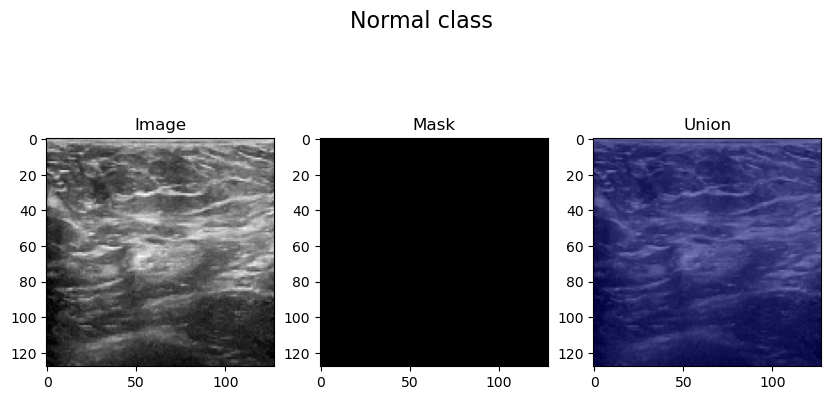

In [36]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

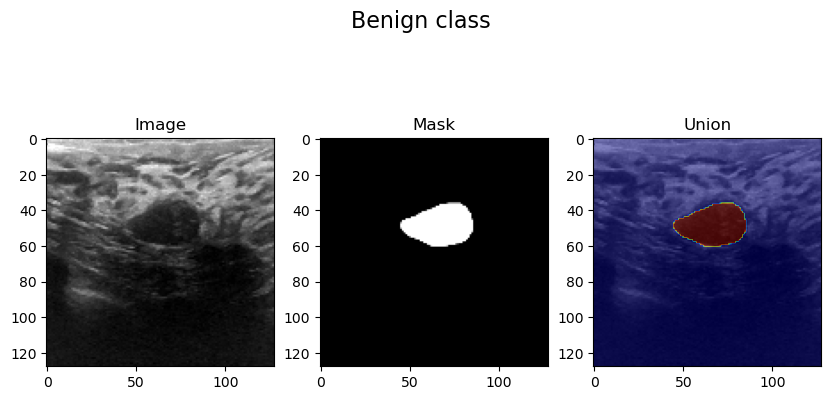

In [37]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

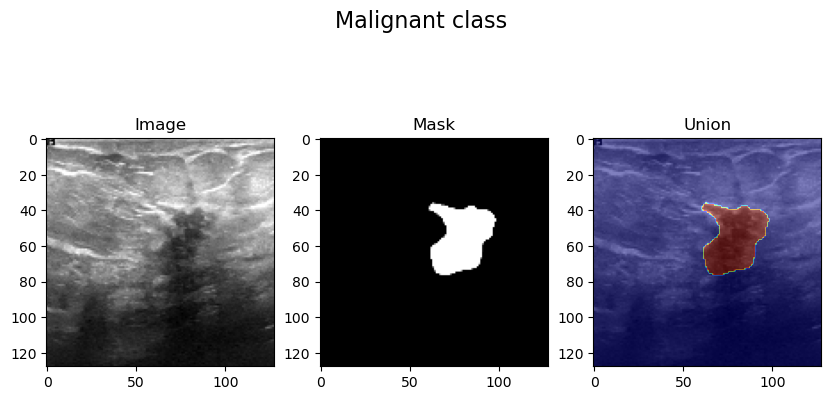

In [38]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

# mask of each class

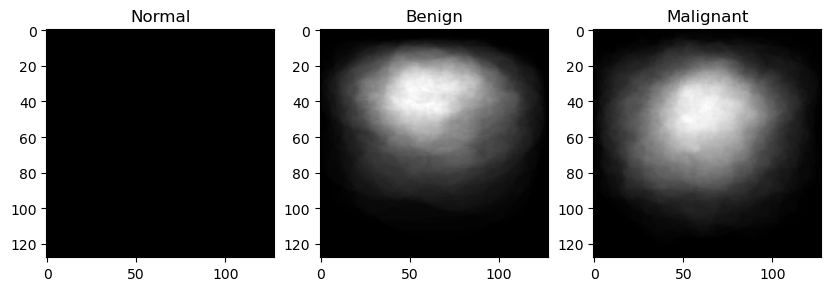

In [39]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

# Mask pre processing

In [40]:
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


# data for training

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


# Unet Model

In [42]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

In [43]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [44]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [45]:
def build_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

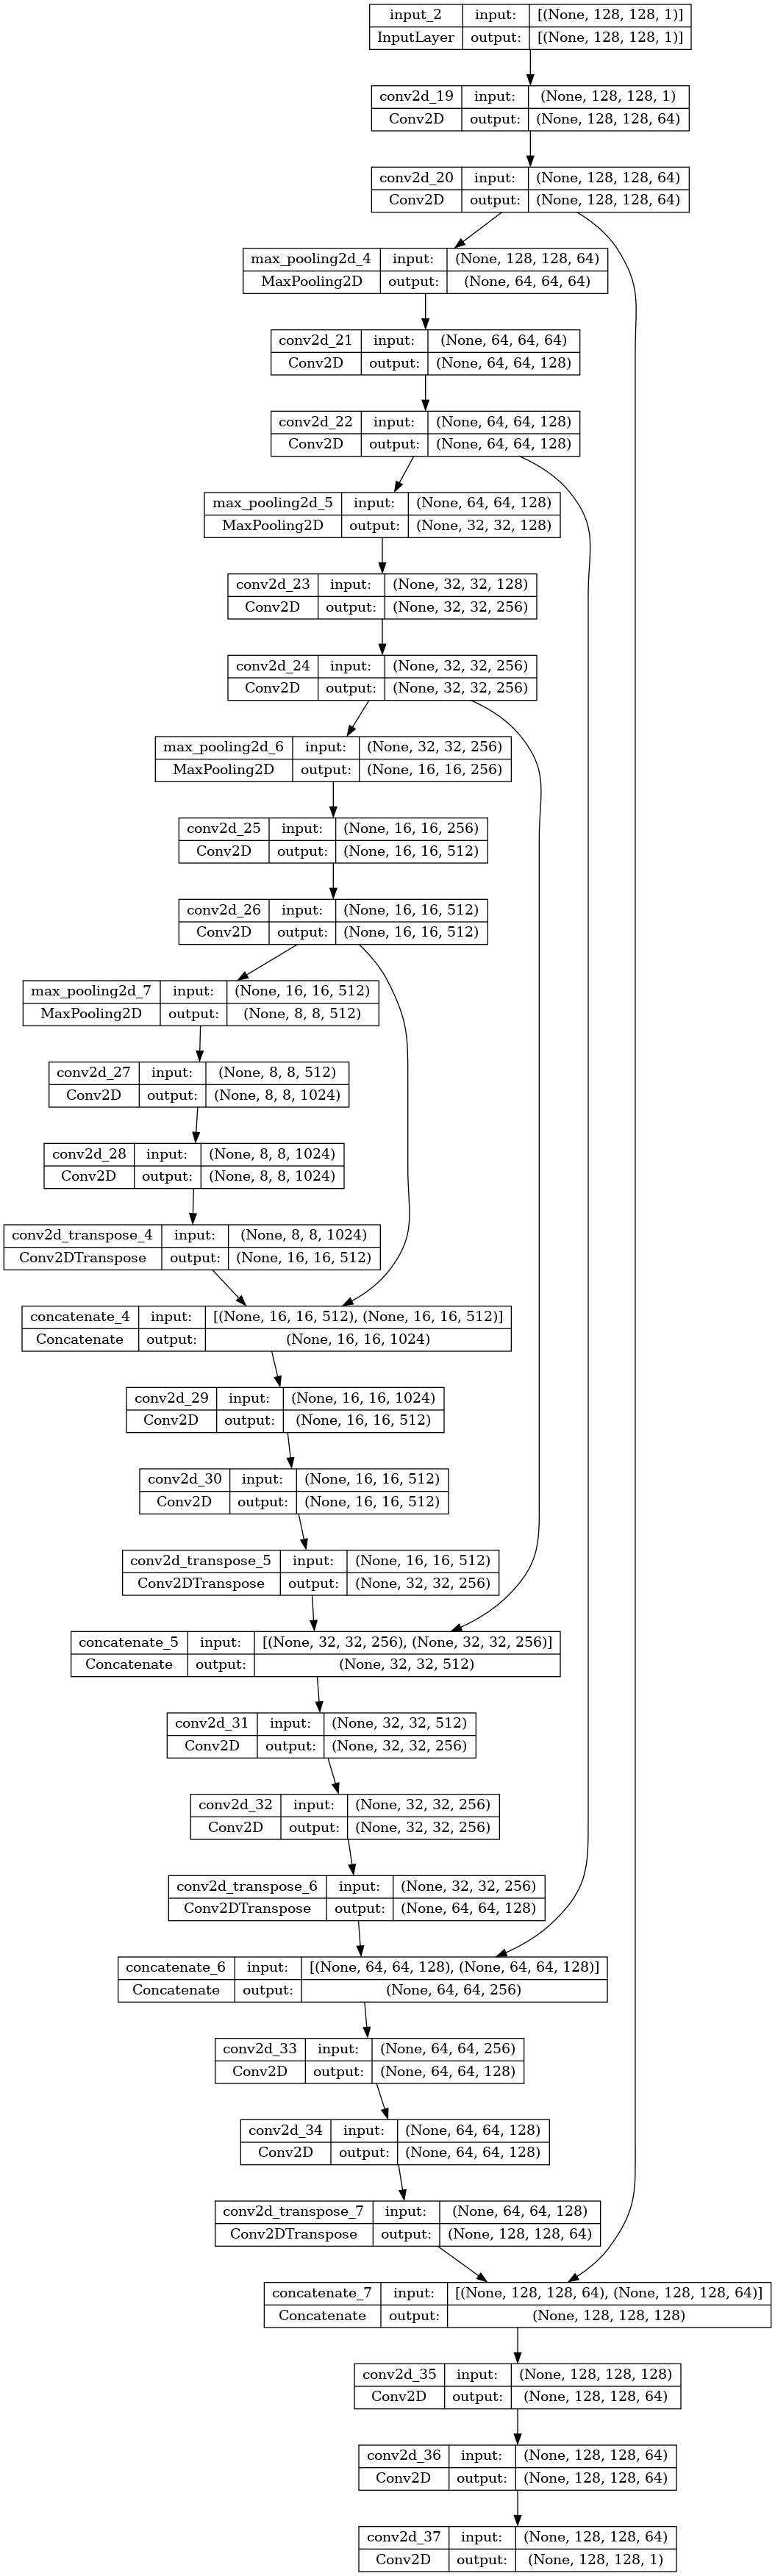

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Summary

In [47]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_19[0][0]']              
                                )                                                             

# Training

In [48]:
history = model.fit(X_train, y_train, epochs = 60, validation_data = (X_test,y_test))

Epoch 1/60
19/19 [==============================] - 10s 212ms/step - loss: 0.5037 - accuracy: 0.8820 - val_loss: 0.3233 - val_accuracy: 0.9196
Epoch 2/60
19/19 [==============================] - 3s 181ms/step - loss: 0.3373 - accuracy: 0.9027 - val_loss: 0.2944 - val_accuracy: 0.9196
Epoch 3/60
19/19 [==============================] - 3s 180ms/step - loss: 0.3641 - accuracy: 0.9028 - val_loss: 0.3070 - val_accuracy: 0.9196
Epoch 4/60
19/19 [==============================] - 3s 181ms/step - loss: 0.4979 - accuracy: 0.8749 - val_loss: 0.3012 - val_accuracy: 0.9196
Epoch 5/60
19/19 [==============================] - 3s 180ms/step - loss: 0.3174 - accuracy: 0.9027 - val_loss: 0.2579 - val_accuracy: 0.9196
Epoch 6/60
19/19 [==============================] - 3s 180ms/step - loss: 0.2912 - accuracy: 0.9026 - val_loss: 0.2536 - val_accuracy: 0.9196
Epoch 7/60
19/19 [==============================] - 3s 180ms/step - loss: 0.2436 - accuracy: 0.9033 - val_loss: 0.2048 - val_accuracy: 0.9198
Epoch

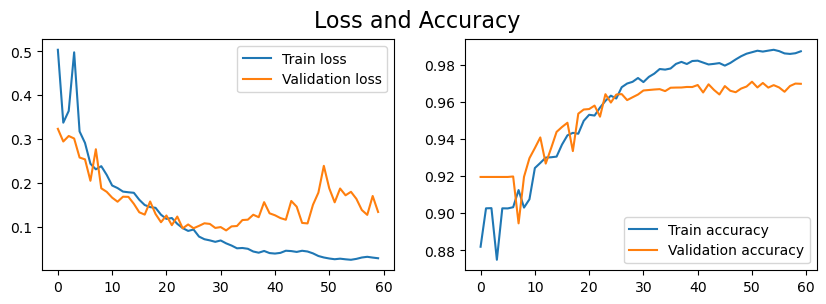

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

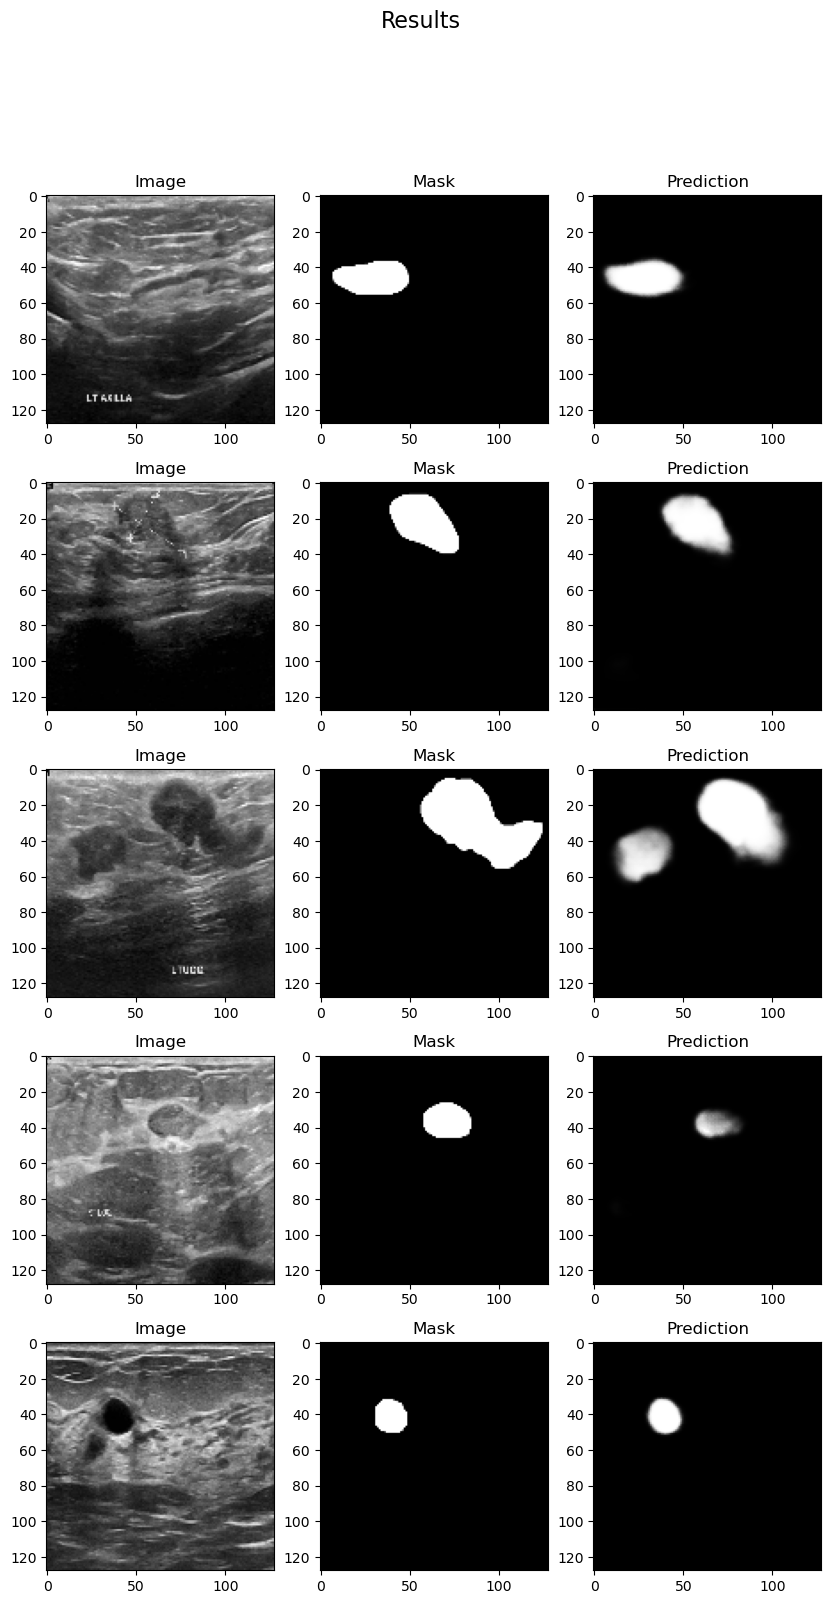

In [52]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [53]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.82450724
Precision Score = 0.770
Recall Score = 0.850
F1 Score = 0.808
